In [1]:
from matplotlib import pyplot as plt

import numpy as np
import cv2 as cv


In [2]:
img = cv.imread('./images/baboon.png', cv.IMREAD_GRAYSCALE)

In [3]:
# nearest neighbor
def inter_nearest(img, indices):
    # round method
    indices = np.round(indices).astype(int)

    # set zero value
    indices = indices.transpose()
    index = np.where((indices[:, 0] < 0) | (indices[:, 0] >= img.shape[0]) |
                     (indices[:, 1] < 0) | (indices[:, 1] >= img.shape[1]))
    indices[index] = 0

    return img[indices[:, 1], indices[:, 0]]


In [4]:
def inter_bilinear(img, indices):
    x = indices[0, :]
    y = indices[1, :]

    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    x1 = x0 + 1
    y1 = y0 + 1

    x0 = np.clip(x0, 0, img.shape[1]-1)
    y0 = np.clip(y0, 0, img.shape[0]-1)
    x1 = np.clip(x1, 0, img.shape[1]-1)
    y1 = np.clip(y1, 0, img.shape[0]-1)

    A = (x1-x) * (y1-y) * img[y0, x0]
    B = (x1-x) * (y-y0) * img[y1, x0]
    C = (x-x0) * (y1-y) * img[y0, x1]
    D = (x-x0) * (y-y0) * img[y1, x1]

    return A + B + C + D


In [5]:
def u(s, a=-0.5):
    st = abs(s)
    if (st >= 0) & (st <= 1):
        return (a+2)*(st**3)-(a+3)*(st**2)+1
    elif (st > 1) & (st <= 2):
        return a*(st**3)-(5*a)*(st**2)+(8*a)*st-4*a
    return 0


def inter_bicubic(img, indices):
    indices = indices.transpose()
    index = np.where((indices[:, 0] >= 1) & (indices[:, 0] < img.shape[0]-2) &
                     (indices[:, 1] >= 1) & (indices[:, 1] < img.shape[1]-2))

    newIndices = indices[index]
    newValues = np.empty(newIndices.shape[0])

    for i in range(newIndices.shape[0]):
        # floor
        point = newIndices[i]
        pointF = np.floor(point)
        pointD = point - pointF

        x1 = pointD[0] + 1
        x2 = pointD[0]
        x3 = -pointD[0] + 1
        x4 = -pointD[0] + 2

        y1 = pointD[1] + 1
        y2 = pointD[1]
        y3 = -pointD[1] + 1
        y4 = -pointD[1] + 2

        A = np.array([u(x1), u(x2), u(x3), u(x4)])
        B = np.array([
            [img[int(point[1]-y1), int(point[0]-x1)], img[int(point[1]-y2), int(point[0]-x1)],
             img[int(point[1]+y3), int(point[0]-x1)], img[int(point[1]+y4), int(point[0]-x1)]],
            [img[int(point[1]-y1), int(point[0]-x2)], img[int(point[1]-y2), int(point[0]-x2)],
             img[int(point[1]+y3), int(point[0]-x2)], img[int(point[1]+y4), int(point[0]-x2)]],
            [img[int(point[1]-y1), int(point[0]+x3)], img[int(point[1]-y2), int(point[0]+x3)],
             img[int(point[1]+y3), int(point[0]+x3)], img[int(point[1]+y4), int(point[0]+x3)]],
            [img[int(point[1]-y1), int(point[0]+x4)], img[int(point[1]-y2), int(point[0]+x4)],
             img[int(point[1]+y3), int(point[0]+x4)], img[int(point[1]+y4), int(point[0]+x4)]]
        ])
        C = np.array([u(y1), u(y2), u(y3), u(y4)])
        newValues[i] = np.dot(np.dot(A, B), C)

    out = np.zeros(indices.shape[0])
    out[index] = newValues
    return out


In [6]:
def warp_perspective(img, M, dsize, inter='nearest'):
    # indices [i, j, 1]
    iY, iX = np.indices(dimensions=dsize)
    indexOutput = np.stack(
        (iX.ravel(), iY.ravel(), np.ones(iY.size))).astype(int)

    # inverse matrix
    IM = np.linalg.inv(M)
    indexInput = IM.dot(indexOutput)
    indexInput /= indexInput[2, :]

    # interpolation type
    if inter == 'nearest':
        out = inter_nearest(img, indexInput)
    elif inter == 'bilinear':
        out = inter_bilinear(img, indexInput)
    elif inter == 'bicubic':
        out = inter_bicubic(img, indexInput)
    else:
        return np.zeros(dsize)

    return out.reshape(dsize)


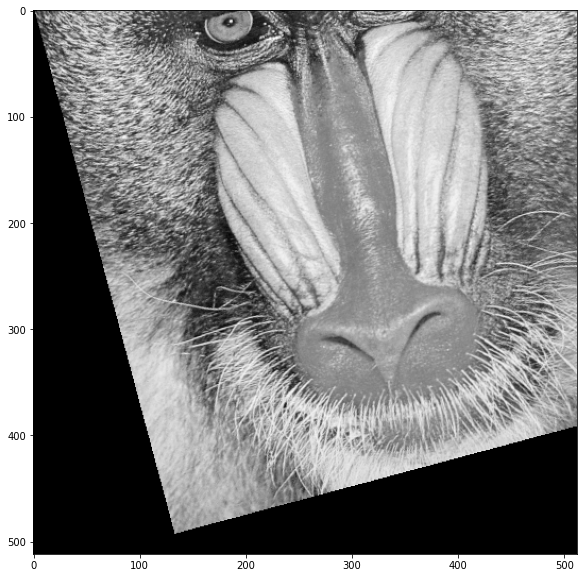

In [7]:
plt.figure(figsize=(10, 10))

tetha = -np.pi / 12
M = np.array([
    [np.cos(tetha), -np.sin(tetha), 0],
    [np.sin(tetha), np.cos(tetha), 0],
    [0, 0, 1]
], dtype='float32')

out = warp_perspective(img, M, (512, 512), 'bicubic')
plt.imshow(out, cmap='gray')
